In [1]:
import numpy as np
import pandas as pd
import glob

import matplotlib
import matplotlib.pyplot as plt

from tqdm import tqdm
import numba
#import bokeh_catplot

import seaborn as sns
import bokeh
import bokeh.plotting
from bokeh.plotting import ColumnDataSource
from bokeh.models import LabelSet
import bokeh.io
bokeh.io.output_notebook()

Loading BokehJS ...

In [2]:
bokeh_catplot?

Object `bokeh_catplot` not found.


In [3]:
#system='mac'
system='pc'

In [4]:
#load each run into a separate dataframe
if system=='pc':
    df1 = pd.read_csv('..\\190926_Deuterium_Transfer_Peak_Areas.csv', comment='#')
    df2 = pd.read_csv('..\\191007_Deuterium_Transfer_Peak_Areas.csv', comment='#')
    df3 = pd.read_csv('..\\191010_Deuterium_Transfer_Peak_Areas.csv', comment='#')
    df4 = pd.read_csv('..\\191015_Deuterium_Transfer_Peak_Areas.csv', comment='#')
    df5 = pd.read_csv('..\\191016_Outlier_Data.csv', comment='#')
    df6 = pd.read_csv('..\\191020_Deuterium_Transfer_Peak_Areas.csv', comment='#')
    df7 = pd.read_csv('..\\191021_Deuterium_Transfer_Peak_Areas.csv', comment='#')
    df8 = pd.read_csv('..\\191022_Deuterium_Transfer_Peak_Areas.csv', comment='#')
    df9 = pd.read_csv('..\\191025_Deuterium_Transfer_Peak_Areas.csv', comment='#')
    df10 = pd.read_csv('..\\191027_Deuterium_Transfer_Peak_Areas.csv', comment='#')
    df11 = pd.read_csv('..\\191031_Deuterium_Transfer_Peak_Areas.csv', comment='#')
    df12 = pd.read_csv('..\\191106_Deuterium_Transfer_Peak_Areas.csv', comment='#')
    df13 = pd.read_csv('..\\191115_Deuterium_Transfer_Peak_Areas.csv', comment='#')
    df14 = pd.read_csv('..\\191119_Deuterium_Transfer_Peak_Areas.csv', comment='#')
    
if system=='mac':
    df1 = pd.read_csv('../190926_Deuterium_Transfer_Peak_Areas.csv', comment='#')
    df2 = pd.read_csv('../191007_Deuterium_Transfer_Peak_Areas.csv', comment='#')
    df3 = pd.read_csv('../191010_Deuterium_Transfer_Peak_Areas.csv', comment='#')
    df4 = pd.read_csv('../191015_Deuterium_Transfer_Peak_Areas.csv', comment='#')
    df5 = pd.read_csv('../191016_Outlier_Data.csv', comment='#')
    df6 = pd.read_csv('../191020_Deuterium_Transfer_Peak_Areas.csv', comment='#')
    df7 = pd.read_csv('../191021_Deuterium_Transfer_Peak_Areas.csv', comment='#')
    df8 = pd.read_csv('../191022_Deuterium_Transfer_Peak_Areas.csv', comment='#')
    df9 = pd.read_csv('../191025_Deuterium_Transfer_Peak_Areas.csv', comment='#')
    df10 = pd.read_csv('../191027_Deuterium_Transfer_Peak_Areas.csv', comment='#')
    df11 = pd.read_csv('../191031_Deuterium_Transfer_Peak_Areas.csv', comment='#')
    df12 = pd.read_csv('../191106_Deuterium_Transfer_Peak_Areas.csv', comment='#')
    df13 = pd.read_csv('../191115_Deuterium_Transfer_Peak_Areas.csv', comment='#')
    df14 = pd.read_csv('../191119_Deuterium_Transfer_Peak_Areas.csv', comment='#')

In [5]:
#add a column to each dataframe listing the date
df1['GCMS Date'] = '190926'
df2['GCMS Date'] = '191007'
df3['GCMS Date'] = '191010'
df4['GCMS Date'] = '191015'
df5['GCMS Date'] = '191016'
df6['GCMS Date'] = '191020'
df7['GCMS Date'] = '191021'
df8['GCMS Date'] = '191022'
df9['GCMS Date'] = '191025'
df10['GCMS Date'] = '191027'
df11['GCMS Date'] = '191031'
df12['GCMS Date'] = '191106'
df13['GCMS Date'] = '191115'
df14['GCMS Date'] = '191119'

#merge data frames into one dataframe
outlier_df=df1.append(df2).append(df3).append(df4).append(df5).append(df6).append(df7).append(df8).append(df9).append(df10).append(df11).append(df12).append(df13).append(df14)
outlier_df = outlier_df[['WellNumber','Outlier','GCMS Date']].drop_duplicates().astype(str)
outlier_df.head()

WellNumber Outlier GCMS Date
0           1       N    190926
6           2       N    190926
12          3      BI    190926
18          4      BI    190926
24          5       N    190926

In [6]:
#Glob together all csvs with the deeplabcut generated position data. 
#The deeplabcut data lists the network iteration of the trained network at the end of the filename
#This value will always be a multiple of 1000
if system=='pc':
    file_list=glob.glob('.\\*\\*000.csv')
    well_list=glob.glob('.\\*\\*Well_Positions.csv')

    #Date sync contains the dates that the video and GCMS data were collected on
    #These two dates are different for every trial
    date_sync = pd.read_csv('..\\DCHC_Date_sync.csv')

if system=='mac':
    file_list=glob.glob('./*/*000.csv')
    well_list=glob.glob('./*/*Well_Positions.csv')

    #Date sync contains the dates that the video and GCMS data were collected on
    #These two dates are different for every trial
    date_sync = pd.read_csv('../DCHC_Date_sync.csv')

In [7]:
file_list[:3]

['.\\190919\\190919_DCHC_transfer_experiment_S_well_1DeepCut_resnet50_DCHC_transfer_analysis_20190919_SOct2shuffle1_80000.csv',
 '.\\190919\\190919_DCHC_transfer_experiment_S_well_2DeepCut_resnet50_DCHC_transfer_analysis_20190919_SOct2shuffle1_80000.csv',
 '.\\190919\\190919_DCHC_transfer_experiment_S_well_3DeepCut_resnet50_DCHC_transfer_analysis_20190919_SOct2shuffle1_80000.csv']

In [8]:
well_list[:2]

['.\\Well_positions\\190919_DCHC_transfer_experiment_S_Well_Positions.csv',
 '.\\Well_positions\\191003_DCHC_transfer_experiment_SP_Well_Positions.csv']

In [9]:
def circle_calc(x,y):
    #determine the equation of the circle circumscribing the central well of the arena using the three points marking the entrances to the antechamber
    #basing this off of Zaz's comment from https://math.stackexchange.com/questions/213658/get-the-equation-of-a-circle-when-given-3-points

    ones=np.ones(3)
    xy=(x**2 + y**2).values

    #creating the minors ofthe matrix of the system of equations
    M11=np.stack((x,y,ones),axis=1)
    M12=np.stack((xy,y,ones),axis=1)
    M13=np.stack((xy,x,ones),axis=1)
    M14=np.stack((xy,x,y),axis=1)

    #calculating the center of the circle as well as the radius
    x_0=1/2 * np.linalg.det(M12)/np.linalg.det(M11)
    y_0=-1/2 * np.linalg.det(M13)/np.linalg.det(M11)
    r=np.sqrt(x_0**2+y_0**2+(np.linalg.det(M14)/np.linalg.det(M11)))
    
    return x_0,y_0,r

In [10]:
#well_df contains the positions, in pixels, for each of the antechamber openings
#in each well from every video
for i,name in tqdm(enumerate(well_list)):
    #load each csv as a dataframe and append to the end of one large dataframe
    if i == 0:
        well_df=pd.read_csv(name,comment='#',usecols=['X','Y','WellNum','Date'])
    else:
        well_df=well_df.append(pd.read_csv(name,comment='#',usecols=['X','Y','WellNum','Date']))

14it [00:00, 169.13it/s]


In [11]:
well_df[['WellNum','Date']].drop_duplicates()

WellNum    Date
0         1  190919
3         2  190919
6         3  190919
9         4  190919
12        5  190919
..      ...     ...
9         4  191115
12        5  191115
15        6  191115
18        7  191115
21        8  191115

[110 rows x 2 columns]

In [12]:
circle_df=well_df[['WellNum','Date']].drop_duplicates()
circle_df['x0']=0
circle_df['y0']=0
circle_df['r']=0
for i,row in well_df[['WellNum','Date']].drop_duplicates().iterrows():
    wellNum = row['WellNum']
    date = row['Date']
    
    x_0,y_0,r = circle_calc(well_df.loc[(well_df['WellNum'] == wellNum) & (well_df['Date'] == date),'X'],
                             well_df.loc[(well_df['WellNum'] == wellNum) & (well_df['Date'] == date),'Y'])
    circle_df.loc[(circle_df['WellNum'] == wellNum) & (circle_df['Date'] == date),'x0'] = x_0

    circle_df.loc[(circle_df['WellNum'] == wellNum) & (circle_df['Date'] == date),'y0'] = y_0
    
    circle_df.loc[(circle_df['WellNum'] == wellNum) & (circle_df['Date'] == date),'r'] = r

In [13]:
#number the three different well positions
well_df['Position'] = well_df.groupby(['Date','WellNum']).cumcount()+1

#convert integer well positions to str
well_df['Position']=well_df['Position'].astype(str)

#unstack data so that there is a multiindex with well position and xy position
well_df = well_df.set_index(['Date','WellNum','Position']).unstack()

#rename the column headings to mash together well position and x or y
well_df.columns=list(map("".join,well_df.columns))

well_df = well_df.reset_index()

well_df = well_df.rename(columns={'Date':'Video Date','WellNum':'WellNumber'})
well_df['Video Date']=well_df['Video Date'].astype(str)
well_df['WellNumber']=well_df['WellNumber'].astype(str)

In [14]:
circle_df=circle_df.rename(columns={'Date':'Video Date','WellNum':'WellNumber'})
circle_df['Video Date']=circle_df['Video Date'].astype(str)
circle_df['WellNumber']=circle_df['WellNumber'].astype(str)
well_df=well_df.merge(circle_df)

In [15]:
well_df.head(2)

Video Date WellNumber   X1   X2   X3   Y1   Y2   Y3          x0          y0  \
0     190919          1  533  368  215  271  551  275  375.177529  366.613544   
1     190919          2  530  367  208  272  551  271  368.709987  364.884329   

            r  
0  184.526102  
1  186.123526

In [16]:
#create dataframe for movement data as well as metadata
df = pd.DataFrame()

for name in tqdm(file_list):
    df_intermediate = pd.read_csv(name,header=[1,2])
    
    #collapse hierarchical column names into one level, separating upper and lower level
    #by a space
    df_intermediate.columns=list(map(" ".join, df_intermediate.columns))
    
    #pull metadata out of filename and add to dataframe
    df_intermediate['species'] = name[name.rfind('_',0,name.rfind('_'))+1]
    df_intermediate['Video Date'] = name[name.find('\\')+1:name.find('\\')+7]
    df_intermediate['WellNumber'] = name[name.find('well')+5:name.find('well')+6]
    df_intermediate['file path'] = name
    
    df = df.append(df_intermediate, ignore_index=True,sort=True)

df['length upper'] = ''

100%|██████████| 109/109 [02:03<00:00,  1.13s/it]


In [17]:
#create a new column named antlength
#antlength is the length of the ant calculated from the head and gaster position data
df['antlength'] = np.sqrt((df['anthead x'] - df['antgaster x'])**2 + 
                          (df['anthead y'] - df['antgaster y'])**2)

In [18]:
#list all dates in the metadata file
np.unique(df['Video Date'])

array(['190919', '191003', '191008', '191012', '191016', '191019',
       '191020', '191021', '191022', '191025', '191029', '191105',
       '191113', '191115'], dtype=object)

In [19]:
# #count is used to specify the position of each subplot
# count=0

# #date specifies the date of the data collection to be analyzed
# date='191105'

# #loop through the indices of the rows from the ID dataframe. These indices should match
# #up with the position of the corresponding dataframe in the dataframe list.
# for i in tqdm(df['WellNumber'].loc[df['Video Date']==date].unique()):
#     subplt = int(str(len(df['WellNumber'].loc[df['Video Date']==date].unique())) + '1' + str(count+1))
#     plt.figure(figsize=(10,20))
#     plt.subplot(subplt)
#     plt.title('Well ' + i)
#     plt.scatter(df.loc[(df['Video Date']==date) & (df['WellNumber'] == i)]['bodyparts coords'][::1000],\
#                 df.loc[(df['Video Date']==date) & (df['WellNumber'] == i)]['antlength'][::1000],alpha=0.1)
#     plt.ylim([40,120])
#     count = count+1

In [20]:
df.loc[df['Video Date']=='190919','length upper'] = 120
df.loc[df['Video Date']=='191003','length upper'] = 120
df.loc[df['Video Date']=='191008','length upper'] = 110
df.loc[df['Video Date']=='191012','length upper'] = 110
df.loc[df['Video Date']=='191016','length upper'] = 110
df.loc[df['Video Date']=='191019','length upper'] = 110
df.loc[df['Video Date']=='191020','length upper'] = 110
df.loc[df['Video Date']=='191021','length upper'] = 110
df.loc[df['Video Date']=='191022','length upper'] = 110
df.loc[df['Video Date']=='191025','length upper'] = 110
df.loc[df['Video Date']=='191029','length upper'] = 125
df.loc[df['Video Date']=='191105','length upper'] = 120
df.loc[df['Video Date']=='191113','length upper'] = 110
df.loc[df['Video Date']=='191115','length upper'] = 120

In [21]:
df = pd.merge(df,date_sync.astype(str),left_on='Video Date',right_on='Video Date')

In [22]:
df = pd.merge(df,outlier_df)

In [23]:
df_intermediate.head()

bodyparts coords   anthead x   anthead y  anthead likelihood  antgaster x  \
0                 0  483.368518  488.636366                 1.0   427.681145   
1                 1  482.941350  488.708469                 1.0   426.757124   
2                 2  482.977324  488.798011                 1.0   426.742526   
3                 3  482.913660  488.874397                 1.0   427.014287   
4                 4  482.904241  488.486059                 1.0   426.977219   

   antgaster y  antgaster likelihood  beetlehead x  beetlehead y  \
0   538.267399              0.835156    424.475604    447.350914   
1   537.868466              0.985187    425.475629    447.826542   
2   538.006269              0.979722    428.401303    444.237520   
3   537.922285              0.983629    429.922062    447.222644   
4   537.894155              0.986807    429.768186    442.381085   

   beetlehead likelihood species Video Date WellNumber  \
0               0.999995       D     191115          8   
1               0.999994       D     191115          8   
2               0.999981       D     191115          8   
3               0.999990       D     191115          8   
4               0.999935       D     191115          8   

                                           file path  
0  .\191115\191115_DCHC_transfer_experiment_D_wel...  
1  .\191115\191115_DCHC_transfer_experiment_D_wel...  
2  .\191115\191115_DCHC_transfer_experiment_D_wel...  
3  .\191115\191115_DCHC_transfer_experiment_D_wel...  
4  .\191115\191115_DCHC_transfer_experiment_D_wel...

In [24]:
df['good frames'] = df['antlength'] < df['length upper']

In [25]:
#Compute the average ant length from the good frames in each
#well from each date
avgLen = df[['antlength','Video Date','WellNumber']].loc[df['good frames']].groupby(['Video Date','WellNumber']).mean()

In [26]:
avgLen

antlength
Video Date WellNumber           
190919     1           68.442639
           2           67.210129
           3           59.638739
           4           59.866883
           5           59.964924
...                          ...
191115     4           80.283725
           5           77.664598
           6           86.277713
           7           75.577042
           8           73.577160

[109 rows x 1 columns]

In [27]:
#Merge the average ant length from each well back into the main dataframe
df = df.merge(avgLen.reset_index().rename(columns={'antlength':'avglen'}))

In [28]:
df.tail()

Video Date WellNumber  antgaster likelihood  antgaster x  antgaster y  \
9284887     191115          8              0.999997   267.153770   686.409268   
9284888     191115          8              0.999999   275.019671   686.287202   
9284889     191115          8              1.000000   276.310576   687.670162   
9284890     191115          8              1.000000   279.308395   689.208228   
9284891     191115          8              1.000000   278.560336   687.895465   

         anthead likelihood   anthead x   anthead y  beetleabdomen likelihood  \
9284887            1.000000  301.774186  626.273796                       NaN   
9284888            0.999999  305.804951  622.126550                       NaN   
9284889            0.999999  304.347534  622.092883                       NaN   
9284890            1.000000  293.503837  620.642348                       NaN   
9284891            0.999998  298.618908  620.095560                       NaN   

         beetleabdomen x  ...  beetlehead y  bodyparts coords  \
9284887              NaN  ...    508.917948             80000   
9284888              NaN  ...    508.946897             80001   
9284889              NaN  ...    508.906325             80002   
9284890              NaN  ...    508.902525             80003   
9284891              NaN  ...    508.766482             80004   

                                                 file path  species  \
9284887  .\191115\191115_DCHC_transfer_experiment_D_wel...        D   
9284888  .\191115\191115_DCHC_transfer_experiment_D_wel...        D   
9284889  .\191115\191115_DCHC_transfer_experiment_D_wel...        D   
9284890  .\191115\191115_DCHC_transfer_experiment_D_wel...        D   
9284891  .\191115\191115_DCHC_transfer_experiment_D_wel...        D   

         length upper  antlength GCMS Date  Outlier  good frames    avglen  
9284887           120  69.389108    191119        N         True  73.57716  
9284888           120  71.164055    191119        N         True  73.57716  
9284889           120  71.319356    191119        N         True  73.57716  
9284890           120  70.019928    191119        N         True  73.57716  
9284891           120  70.704833    191119        N         True  73.57716  

[5 rows x 23 columns]

## Touching metric
The metric for touching is if the head of the beetle (or tip of abdomen as well in the case of Platyusa) is within the bounds of an ellipse drawn around the ant. In the case that the length of the ant is above the upper bound specified above (i.e. good frames == False in practice this either corresponds to a mislabeling by deeplabcut or more likely the ant has been bitten in half by a platyusa) then the ant and beetle are touching if either the head or tip of abdomen of the beetle are within 1 body length of either ant part.

In [29]:
#calculating the distance between the head of the beetle and the head of the ant
df['head2head'] = np.sqrt((df['beetlehead x'] - df['anthead x'])**2 +
                          (df['beetlehead y'] - df['anthead y'])**2)
#calculating the distance between the head of the beetle and the gaster of the ant
df['head2butt'] = np.sqrt((df['beetlehead x'] - df['antgaster x'])**2 +
                          (df['beetlehead y'] - df['antgaster y'])**2)

I am going to use a trick in the following code block that is most likely a fairly poor programming practice. I have position data for the beetleabdomen of 
Platyusa but not for the abdomen of Sceptobius and Dalotia. The entries in the beetleabdomen column are nan for Sceptobius and Dalotia, so if I calculate distances for Platyusa (using both the head and the abdomen) the nans should cause the abdomen calculations to not be used, simplifying down to the case of the head distances.

In [30]:
#calculating the distance between the abdomen tip of the beetle and the head of the ant
#this column will have nans for sceptobius and dalotia
df['butt2head'] = np.sqrt((df['beetleabdomen x'] - df['anthead x'])**2 +
                          (df['beetleabdomen y'] - df['anthead y'])**2)

#calculating the distance between the abdomen tip of the beetle and the gaster of the ant
#this column will have nans for Sceptobius and Dalotia
df['butt2butt'] = np.sqrt((df['beetleabdomen x'] - df['antgaster x'])**2 +
                          (df['beetleabdomen y'] - df['antgaster y'])**2)

In [31]:
#calcate the combined distance of the beetle head to the ant head and ant gaster
df['ellipse distance'] = df['head2head'] + df['head2butt']

#calculate the combined distance of the beetle abdomen to the ant head and ant gaster
#this collumn will have nans for Sceptobius and Dalotia
df['butt ellipse distance'] = df['butt2head'] + df['butt2butt']

#calculate the lesser of the head ellipse distance and abdomen ellipse distance
#if the abdomen ellipse distance is less, set those rows of ellipse distance 
#equal to the abdomen ellipse distance
df.loc[df['butt ellipse distance'] > df['ellipse distance'],'ellipse distance'] = \
    df.loc[df['butt ellipse distance'] > df['ellipse distance'],'butt ellipse distance']

In [32]:
#If ellipse distance is less than 1.4 times the length of the ant, the ant and beetle are touching
#so long as the frames are good frames. For the frames that are not good, the ant and beetle are 
#touching if any of the distances between the ant or beetle head or abdomen are less than the 
#average length of the ant.
df['touching'] = ((df['antlength']*1.4 > df['ellipse distance'])&df['good frames']) | \
                     ((~df['good frames']) & \
                      ((df['head2head']<df['avglen']) | (df['head2butt']<df['avglen']) | \
                       (df['butt2head']<df['avglen']) | (df['butt2butt']<df['avglen'])))

In [33]:
df.tail()

Video Date WellNumber  antgaster likelihood  antgaster x  antgaster y  \
9284887     191115          8              0.999997   267.153770   686.409268   
9284888     191115          8              0.999999   275.019671   686.287202   
9284889     191115          8              1.000000   276.310576   687.670162   
9284890     191115          8              1.000000   279.308395   689.208228   
9284891     191115          8              1.000000   278.560336   687.895465   

         anthead likelihood   anthead x   anthead y  beetleabdomen likelihood  \
9284887            1.000000  301.774186  626.273796                       NaN   
9284888            0.999999  305.804951  622.126550                       NaN   
9284889            0.999999  304.347534  622.092883                       NaN   
9284890            1.000000  293.503837  620.642348                       NaN   
9284891            0.999998  298.618908  620.095560                       NaN   

         beetleabdomen x  ...  Outlier  good frames    avglen   head2head  \
9284887              NaN  ...        N         True  73.57716  407.376718   
9284888              NaN  ...        N         True  73.57716  402.311169   
9284889              NaN  ...        N         True  73.57716  403.674459   
9284890              NaN  ...        N         True  73.57716  413.707032   
9284891              NaN  ...        N         True  73.57716  408.659713   

          head2butt butt2head butt2butt  ellipse distance  \
9284887  460.322130       NaN       NaN        867.698848   
9284888  453.003395       NaN       NaN        855.314564   
9284889  452.340640       NaN       NaN        856.015100   
9284890  450.209230       NaN       NaN        863.916261   
9284891  450.413496       NaN       NaN        859.073209   

         butt ellipse distance touching  
9284887                    NaN    False  
9284888                    NaN    False  
9284889                    NaN    False  
9284890                    NaN    False  
9284891                    NaN    False  

[5 rows x 30 columns]

## The behavioral arena that I used is not completely open but instead constists of a central chamber surrounded by three antechambers.
The distance from any one point in the arena to any other point thne can thus be expressed in two ways. I already calculated the euclidean distance between various parts of the ant and various parts of the beetle. A second way to calculate the distance would be to consider the distance that one of the insects would have to walk to get to the other insect.

In [34]:
#Merge antechamber opening positions into the main dataframe
df = df.merge(well_df)

In [35]:
#determine the distance between a label and the three antechamber entrance locations
df['ant dist1']=np.sqrt((df['anthead x']-df['X1'])**2 + (df['anthead y']-df['Y1'])**2)
df['ant dist2']=np.sqrt((df['anthead x']-df['X2'])**2 + (df['anthead y']-df['Y2'])**2)
df['ant dist3']=np.sqrt((df['anthead x']-df['X3'])**2 + (df['anthead y']-df['Y3'])**2)

df['beetle dist1']=np.sqrt((df['beetlehead x']-df['X1'])**2 + (df['beetlehead y']-df['Y1'])**2)
df['beetle dist2']=np.sqrt((df['beetlehead x']-df['X2'])**2 + (df['beetlehead y']-df['Y2'])**2)
df['beetle dist3']=np.sqrt((df['beetlehead x']-df['X3'])**2 + (df['beetlehead y']-df['Y3'])**2)

#determine which of the three antechamber entrances is closest to the given point
df['ant closest']=0*((df['ant dist1']<df['ant dist2'])&(df['ant dist1']<df['ant dist3'])) + \
                  1*((df['ant dist2']<df['ant dist1'])&(df['ant dist2']<df['ant dist3'])) + \
                  2*((df['ant dist3']<df['ant dist1'])&(df['ant dist3']<df['ant dist2']))

df['beetle closest']=0*((df['beetle dist1']<df['beetle dist2'])&(df['beetle dist1']<df['beetle dist3'])) + \
                     1*((df['beetle dist2']<df['beetle dist1'])&(df['beetle dist2']<df['beetle dist3'])) + \
                     2*((df['beetle dist3']<df['beetle dist1'])&(df['beetle dist3']<df['beetle dist2']))

In [36]:
df.head(2)

Video Date WellNumber  antgaster likelihood  antgaster x  antgaster y  \
0     190919          1              0.999999   361.601315   394.884507   
1     190919          1              0.999999   361.411461   395.220237   

   anthead likelihood   anthead x   anthead y  beetleabdomen likelihood  \
0                 1.0  427.767942  399.401206                       NaN   
1                 1.0  428.026720  399.485341                       NaN   

   beetleabdomen x  ...          y0           r   ant dist1   ant dist2  \
0              NaN  ...  366.613544  184.526102  166.014023  162.955212   
1              NaN  ...  366.613544  184.526102  165.915256  162.972081   

    ant dist3 beetle dist1 beetle dist2  beetle dist3  ant closest  \
0  246.466746   151.489186   473.027863    388.936099            1   
1  246.732616   188.736573   506.138736    398.959815            1   

  beetle closest  
0              0  
1              0  

[2 rows x 47 columns]

In [37]:
df[['ant dist1','ant dist2','ant dist3']].head().values

array([[166.01402286, 162.95521225, 246.46674645],
       [165.91525597, 162.972081  , 246.73261571],
       [165.85481206, 163.03309313, 246.73091156],
       [166.46090631, 162.46504277, 246.60648784],
       [166.56954559, 162.35532856, 246.61005073]])

In [38]:
#determine if the ant and the beetle are inside or outside of the circle
#plug in the position of the beetle into the left side of (x_0-x)**2 + (y_0-y)**2 < r**2
#and determine if the value is smaller than than the right side
df['ant in circle'] = np.sqrt((df['anthead x']-x_0)**2 + (df['anthead y']-y_0)**2) < r
df['beetle in circle'] = np.sqrt((df['beetlehead x']-x_0)**2 + (df['beetlehead y']-y_0)**2) < r

#creating columns for the location of the beetle and ant. If the beetle is in the center of the circle,
#the location coding is 3, otherwise it is 0-3 starting in the bottom right chamber working counterclockwise
df['ant loc'] = 3*df['ant in circle'] + (df['ant closest'] & ~df['ant in circle'])
df['beetle loc'] = 3*df['beetle in circle'] + (df['beetle closest'] & ~df['beetle in circle'])

#determining all of the possible distances that need to be measured
#euclidean distance between the ant and the beetle
euclidean_dist=df['head2head']

In [39]:
#distance from the beetle to the nearest antechamber entrance
beetle2beetleentrance=np.min(df[['beetle dist1','beetle dist2','beetle dist3']],axis=1)

#distance from the ant to the nearest antechamber entrance
ant2antentrance=np.min(df[['ant dist1','ant dist2','ant dist3']],axis=1)

#distance from the beetle to the antechamber entrance nearest the ant
beetle2antentrance=df['beetle dist1'].loc[df['ant dist1'] == ant2antentrance].add(
                   df['beetle dist2'].loc[df['ant dist2'] == ant2antentrance],fill_value=0).add(
                   df['beetle dist3'].loc[df['ant dist3'] == ant2antentrance],fill_value=0)

#distance from the ant to the antechamber entrance nearest the beetle
ant2beetleentrance=df['ant dist1'].loc[df['beetle dist1']==beetle2beetleentrance].add(
                   df['ant dist2'].loc[df['beetle dist2']==beetle2beetleentrance],fill_value=0).add(
                   df['ant dist3'].loc[df['beetle dist3']==beetle2beetleentrance],fill_value=0)

In [40]:
#calculate the distance between each of the three entrances
df['E1E2'] = np.sqrt((df['X1']-df['X2'])**2 + (df['Y1']-df['Y2'])**2)
df['E1E3'] = np.sqrt((df['X1']-df['X3'])**2 + (df['Y1']-df['Y3'])**2)
df['E2E3'] = np.sqrt((df['X3']-df['X2'])**2 + (df['Y3']-df['Y2'])**2)


#distance between the two antechamber entrances
#the last line with 0*df['E2E3'] sets the entrance2entrance value to zero
#any place that the two organisms are both closest to the same entrance
entrance2entrance=df['E1E2'].loc[((df['ant closest']==0) & (df['beetle closest']==1)) | \
                                 ((df['ant closest']==1) & (df['beetle closest']==0))].add(
                  df['E1E3'].loc[((df['ant closest']==0) & (df['beetle closest']==2)) | \
                                 ((df['ant closest']==2) & (df['beetle closest']==0))],fill_value=0).add(
                  df['E2E3'].loc[((df['ant closest']==2) & (df['beetle closest']==1)) | \
                                 ((df['ant closest']==1) & (df['beetle closest']==2))],fill_value=0).add(
                  0*df['E2E3'].loc[df['ant closest']==df['beetle closest']],fill_value=0)

In [41]:
#calculating the distance between the ant and the beetle
#If the two organisms are in the same antechamber, use the euclidean distance.
#If one of the organisms is in the center and the other is in one of the antechambers
#calculate the distance from the outer organism to that organsims antechamber entrance
#and add that to the distance from the antechamber to the second organism.
#If both organisms are on the perifery in different antechambers, calculate the distance
#from both of the organisms to their respective antechamber entrances and add those distances
#to the distance between the two antechamber entrances
df['actual distance'] = euclidean_dist.loc[df['ant loc']==df['beetle loc']].add(
    ((ant2beetleentrance+beetle2beetleentrance).loc[df['ant loc']==3].add(
        (beetle2antentrance+ant2antentrance).loc[df['beetle loc']==3],fill_value=0).add(
        (ant2antentrance+beetle2beetleentrance+entrance2entrance).loc[(df['ant loc']!=3)&(df['beetle loc']!=3)],fill_value=0)
    ).loc[df['ant loc']!=df['beetle loc']],fill_value=0)

In [42]:
df.head()

Video Date WellNumber  antgaster likelihood  antgaster x  antgaster y  \
0     190919          1              0.999999   361.601315   394.884507   
1     190919          1              0.999999   361.411461   395.220237   
2     190919          1              1.000000   361.357584   395.020876   
3     190919          1              0.999999   361.437400   394.975922   
4     190919          1              1.000000   361.298920   395.039374   

   anthead likelihood   anthead x   anthead y  beetleabdomen likelihood  \
0                 1.0  427.767942  399.401206                       NaN   
1                 1.0  428.026720  399.485341                       NaN   
2                 1.0  428.056251  399.431414                       NaN   
3                 1.0  427.648703  399.881099                       NaN   
4                 1.0  427.595800  399.978169                       NaN   

   beetleabdomen x  ...  ant closest  beetle closest  ant in circle  \
0              NaN  ...            1               0           True   
1              NaN  ...            1               0           True   
2              NaN  ...            1               0           True   
3              NaN  ...            1               0           True   
4              NaN  ...            1               0           True   

   beetle in circle  ant loc beetle loc   E1E2        E1E3        E2E3  \
0             False        3          0  325.0  318.025156  315.570911   
1             False        3          0  325.0  318.025156  315.570911   
2             False        3          0  325.0  318.025156  315.570911   
3             False        3          0  325.0  318.025156  315.570911   
4             False        3          0  325.0  318.025156  315.570911   

  actual distance  
0      317.503209  
1      354.651829  
2      355.920831  
3      384.898093  
4      416.649602  

[5 rows x 55 columns]

In [43]:
#Compute the average ant length from the good frames in each
#well from each date
touching = df[['touching','Video Date','species','WellNumber','Outlier']].groupby(['Video Date','WellNumber','species','Outlier']).mean().reset_index()

In [44]:
touching

Video Date WellNumber species Outlier  touching
0       190919          1       S       N  0.322831
1       190919          2       S       N  0.135322
2       190919          3       S      BI  0.189996
3       190919          4       S      BI  0.193442
4       190919          5       S       N  0.245093
..         ...        ...     ...     ...       ...
104     191115          4       D       N  0.043772
105     191115          5       D       N  0.069458
106     191115          6       D       N  0.003462
107     191115          7       D       N  0.073508
108     191115          8       D       N  0.011712

[109 rows x 5 columns]

In [45]:
def box_and_whisker(data,plt,x_vals,y_vals):
    
    groups = data.groupby(x_vals)
    q1 = groups.quantile(q=0.25)
    q2 = groups.quantile(q=0.5)
    q3 = groups.quantile(q=0.75)
    iqr = q3 - q1
    upper = q3 + 1.5*iqr
    lower = q1 - 1.5*iqr

    # find the outliers for each category
    def outliers(group):
        cat = group.name
        return group[(group[y_vals] > upper.loc[cat][y_vals]) | (group[y_vals] < lower.loc[cat][y_vals])][y_vals]
    out = groups.apply(outliers).dropna()

    # prepare outlier data for plotting, we need coordinates for every outlier.
    if not out.empty:
        outx = []
        outy = []
        for keys in out.index:
            outx.append(keys[0])
            outy.append(out.loc[keys[0]].loc[keys[1]])

    # if no outliers, shrink lengths of stems to be no longer than the minimums or maximums
    qmin = groups.quantile(q=0.00)
    qmax = groups.quantile(q=1.00)
    upper[y_vals] = [min([x,y]) for (x,y) in zip(list(qmax.loc[:,y_vals]),upper[y_vals])]
    lower[y_vals] = [max([x,y]) for (x,y) in zip(list(qmin.loc[:,y_vals]),lower[y_vals])]

    # stems
    plt.segment(q3.reset_index()[x_vals], upper[y_vals], q3.reset_index()[x_vals], q3[y_vals], line_color="black")
    plt.segment(q3.reset_index()[x_vals], lower[y_vals], q3.reset_index()[x_vals], q1[y_vals], line_color="black")

    #boxes
    plt.vbar(q3.reset_index()[x_vals], 0.7, q2[y_vals], q3[y_vals], fill_color=None, line_color="black")
    plt.vbar(q3.reset_index()[x_vals], 0.7, q1[y_vals], q2[y_vals], fill_color=None, line_color="black")

    # whiskers (almost-0 height rects simpler than segments)
    plt.vbar(q3.reset_index()[x_vals], top=lower[y_vals],bottom=lower[y_vals], width=0.2, line_color="black")
    plt.vbar(q3.reset_index()[x_vals], top=upper[y_vals],bottom=upper[y_vals], width=0.2, line_color="black")
    
    return plt

In [46]:
Identifiers = ['S','P','D']
p = bokeh.plotting.figure(plot_width=800,
                          plot_height=600,
                          title='Percent Touching',
                          x_range=Identifiers,
                          y_axis_label='percent touching',
                          y_axis_type='linear')

colors=['#5F56FF','#C42F2F','#832161']

p = box_and_whisker(touching[['species','touching']],p,'species','touching')

data = {'species': touching['species'],
        'touching': touching['touching'],
        'Outlier': touching['Outlier']}

source = ColumnDataSource(data=data)

# p.circle(bokeh.transform.jitter('species',  width=0.2,range=p.x_range),
#         'touching',
#         source=source,
#         color=bokeh.transform.factor_cmap('species',colors,Identifiers),
#         alpha=0.6,
#         size=7)

outcols=['lime','purple','orange','pink','cyan']
outlabs=['AI','A','BI','B','Y']

p.circle(bokeh.transform.jitter('species',  width=0.2,range=p.x_range),
        'touching',
        source=source,
        color=bokeh.transform.factor_cmap('Outlier',outcols,outlabs),
        alpha=0.6,
        size=7,
        legend='Outlier')
        

p.xgrid.visible = False
p.ygrid.visible = False

# Add custom axis

bokeh.io.show(p)

In [47]:
def ecdf_func(x):
    return np.sort(x), np.arange(len(x))/len(x)

In [74]:
Identifiers = ['S','P','D']
p = bokeh.plotting.figure(plot_width=800,
                          plot_height=600,
                          title='Percent Touching',
                          x_range=Identifiers,
                          y_axis_label='percent touching',
                          y_axis_type='linear')

colors=['#5F56FF','#C42F2F','#BAC44B']

p = box_and_whisker(touching[['species','touching']].loc[touching['Outlier']=='N'],p,'species','touching')

data = {'species': touching['species'].loc[touching['Outlier']=='N'],
        'touching': touching['touching'].loc[touching['Outlier']=='N'],
        'Outlier': touching['Outlier'].loc[touching['Outlier']=='N']}

source = ColumnDataSource(data=data)

p.circle(bokeh.transform.jitter('species',  width=0.2,range=p.x_range),
        'touching',
        source=source,
        color=bokeh.transform.factor_cmap('species',colors,Identifiers),
        alpha=0.6,
        size=7)

outcols=['lime','purple','orange','pink','cyan']
outlabs=['AI','A','BI','B','Y']

# p.circle(bokeh.transform.jitter('species',  width=0.2,range=p.x_range),
#         'touching',
#         source=source,
#         color=bokeh.transform.factor_cmap('Outlier',outcols,outlabs),
#         alpha=0.6,
#         size=7,
#         legend='Outlier')
        

p.xgrid.visible = False
p.ygrid.visible = False

# Add custom axis

bokeh.io.show(p)
p.output_backend = "svg"
bokeh.io.export_svgs(p, filename="percent_touching.svg")

['percent_touching.svg']

In [49]:
df.head(2)

Video Date WellNumber  antgaster likelihood  antgaster x  antgaster y  \
0     190919          1              0.999999   361.601315   394.884507   
1     190919          1              0.999999   361.411461   395.220237   

   anthead likelihood   anthead x   anthead y  beetleabdomen likelihood  \
0                 1.0  427.767942  399.401206                       NaN   
1                 1.0  428.026720  399.485341                       NaN   

   beetleabdomen x  ...  ant closest  beetle closest  ant in circle  \
0              NaN  ...            1               0           True   
1              NaN  ...            1               0           True   

   beetle in circle  ant loc beetle loc   E1E2        E1E3        E2E3  \
0             False        3          0  325.0  318.025156  315.570911   
1             False        3          0  325.0  318.025156  315.570911   

  actual distance  
0      317.503209  
1      354.651829  

[2 rows x 55 columns]

For plotting iterate over groupby object, aggregating with ecdf function. Check out Justin Bois's bebi103 github

In [50]:
plotting_df=df[::50].loc[df['Outlier']=='N']

In [51]:
max(df['actual distance'])

958.0176522266163

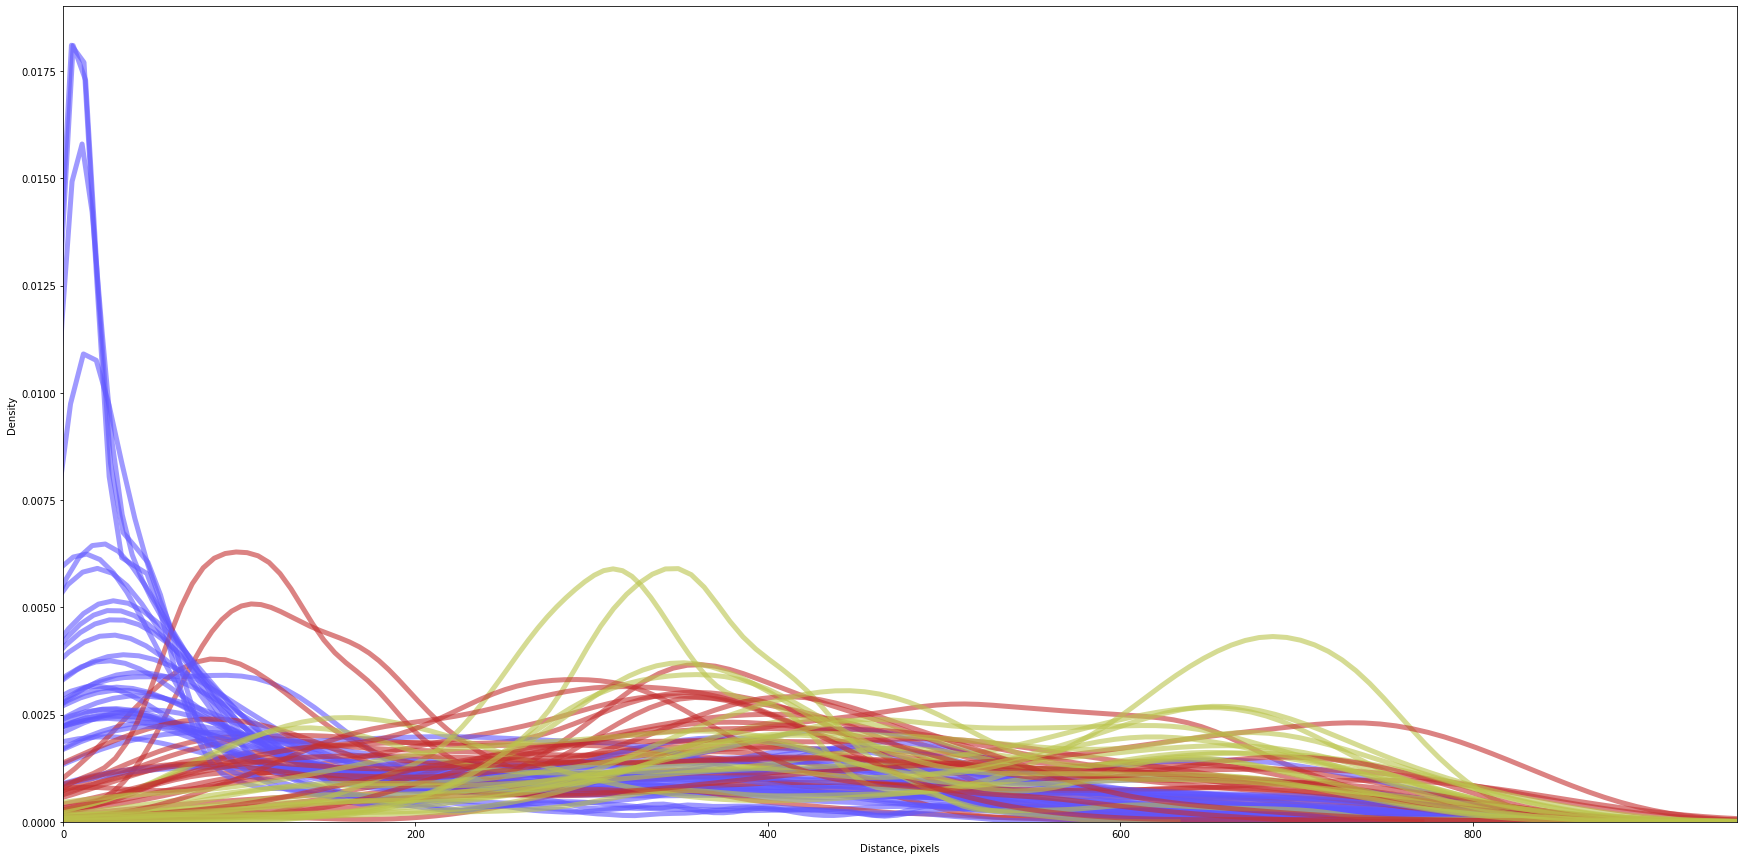

In [52]:
plt.figure(figsize=(30,15))
plt.xlim((0,950))
for i,row in plotting_df[['Video Date','WellNumber','species']].drop_duplicates().iterrows(): 
    if row['species'] == 'P':
        color='#C42F2F'
    if row['species'] == 'S':
        color='#5F56FF'
    if row['species'] == 'D':
        color='#BAC44B'

    sns.distplot(plotting_df['actual distance'].loc[
                                    (plotting_df['Video Date']==row['Video Date']) &\
                                    (plotting_df['WellNumber']==row['WellNumber'])],
                 hist = False, 
                 kde = True,
                 kde_kws = {'linewidth': 5,'color':color,'alpha':0.6})

# Plot formatting

plt.xlabel('Distance, pixels')
plt.ylabel('Density')
plt.savefig("2020_10_19_Distance_Density.svg")

Text(0, 0.5, 'Density')

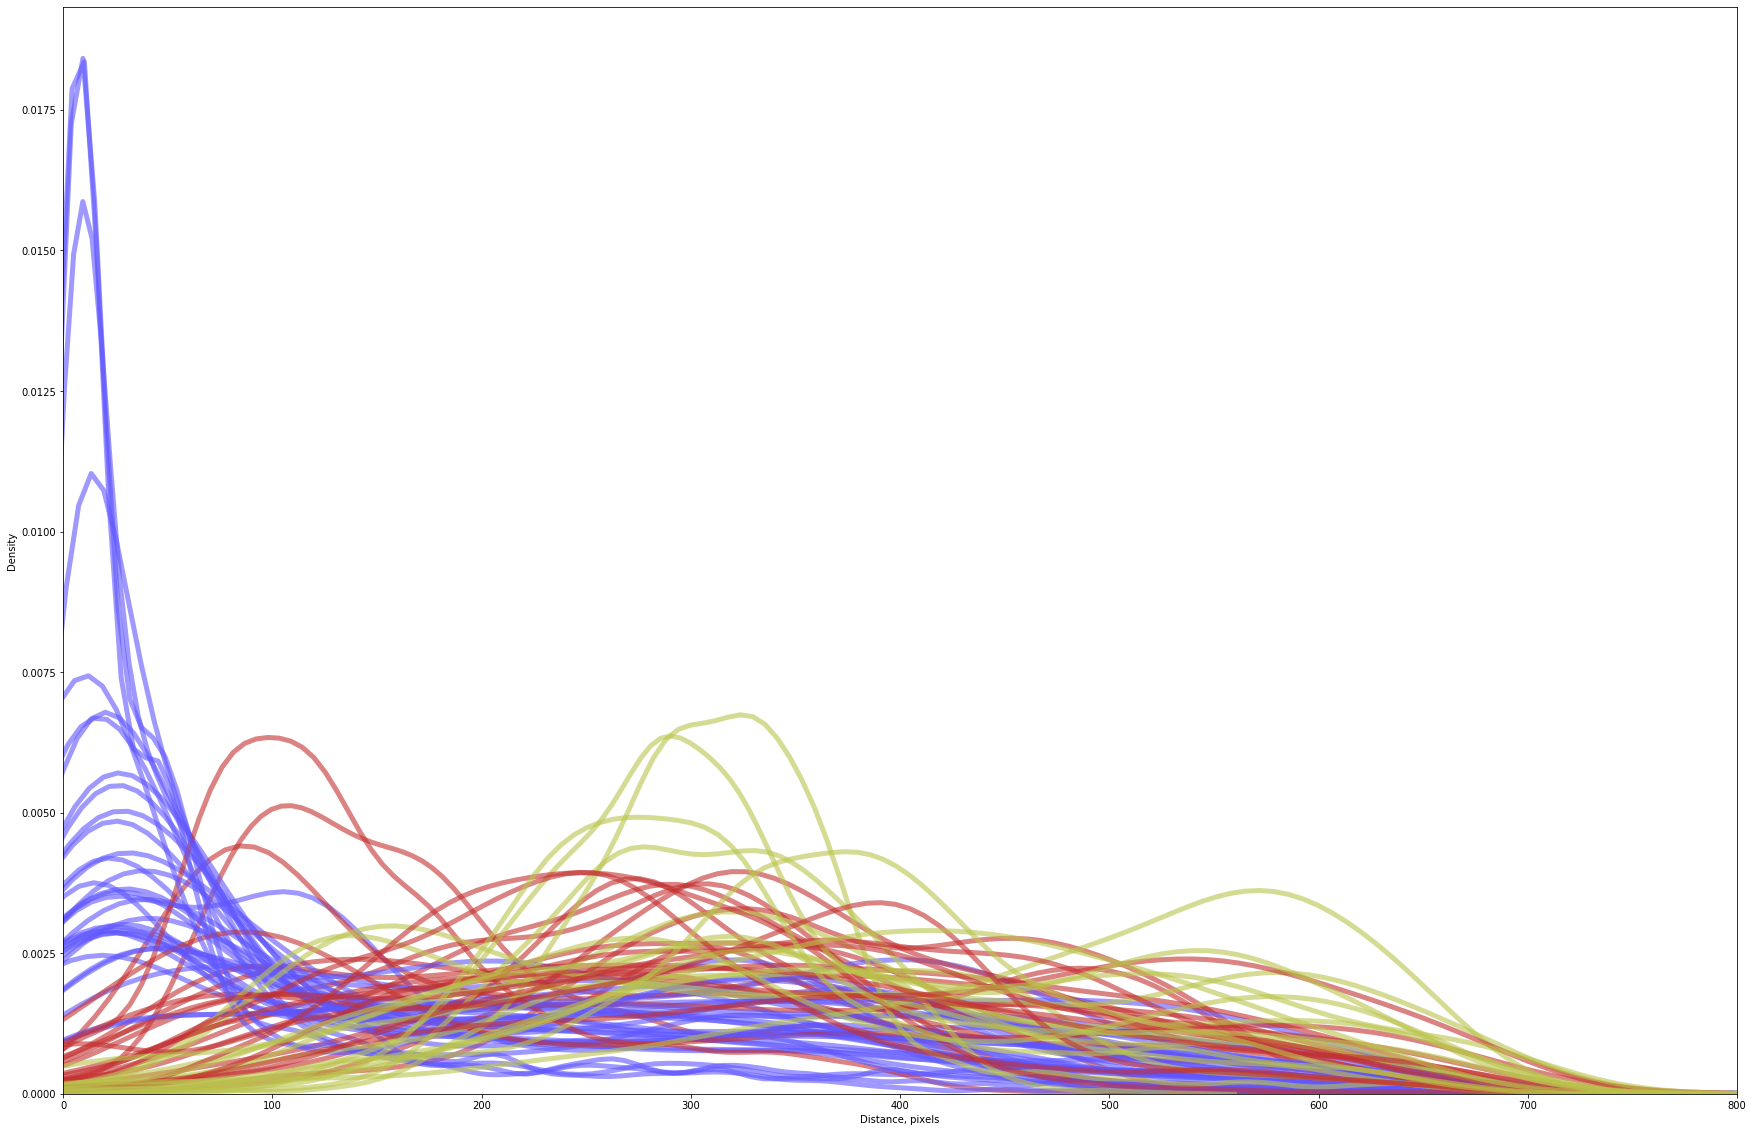

In [53]:
plt.figure(figsize=(30,20))
plt.xlim((0,800))
for i,row in plotting_df[['Video Date','WellNumber','species']].drop_duplicates().iterrows(): 
    if row['species'] == 'P':
        color='#C42F2F'
    if row['species'] == 'S':
        color='#5F56FF'
    if row['species'] == 'D':
        color='#BAC44B'

    sns.distplot(plotting_df['head2head'].loc[
                                    (plotting_df['Video Date']==row['Video Date']) &\
                                    (plotting_df['WellNumber']==row['WellNumber'])],
                 hist = False, 
                 kde = True,
                 kde_kws = {'linewidth': 5,'color':color,'alpha':0.6})

# Plot formatting

plt.xlabel('Distance, pixels')
plt.ylabel('Density')

In [54]:
df_test = df[::100].loc[df['Outlier']=='N'].sort_values(['Video Date','WellNumber','head2head'])

In [55]:
df_test['Rank'] = df_test.sort_values(['Video Date','WellNumber','head2head']).groupby(['Video Date','WellNumber']).cumcount()+1

In [56]:
df_test=df_test.merge(df_test[['Video Date','WellNumber','head2head']].sort_values(
    ['Video Date','WellNumber','head2head']).groupby(
    ['Video Date','WellNumber']).count().rename(
    columns={'head2head':'count'}).reset_index())

In [57]:
df_test['Rank'] = df_test['Rank']/df_test['count']

In [58]:
p = bokeh.plotting.figure(plot_width=800,
                          plot_height=600,
                          y_axis_label='ECDF')

for i,row in df_test[['Video Date','WellNumber','species']].drop_duplicates().iterrows(): 
    if row['species'] == 'P':
        color='#C42F2F'
    if row['species'] == 'S':
        color='#5F56FF'
    if row['species'] == 'D':
        color='#832161'
    

    p.line(df_test['head2head'].loc[
                                    (df_test['Video Date']==row['Video Date']) &\
                                    (df_test['WellNumber']==row['WellNumber'])],
           df_test['Rank'].loc[
                                    (df_test['Video Date']==row['Video Date']) &\
                                    (df_test['WellNumber']==row['WellNumber'])],
             color=color,
             alpha=0.6,
             line_width=3)


p.xgrid.visible = False
p.ygrid.visible = False

# Add custom axis

bokeh.io.show(p)

In [59]:
df_test2 = df[::100].loc[df['Outlier']=='N'].sort_values(['Video Date','WellNumber','actual distance'])

In [60]:
df_test2['Rank'] = df_test2.sort_values(['Video Date','WellNumber','actual distance']).groupby(['Video Date','WellNumber']).cumcount()+1

In [61]:
df_test2=df_test2.merge(df_test2[['Video Date','WellNumber','actual distance']].sort_values(
    ['Video Date','WellNumber','actual distance']).groupby(
    ['Video Date','WellNumber']).count().rename(
    columns={'actual distance':'count'}).reset_index())

In [62]:
df_test2['Rank'] = df_test2['Rank']/df_test2['count']

In [63]:
df_test3 = df[::100].loc[df['Outlier']=='N'].reset_index()

In [64]:
p = bokeh.plotting.figure(plot_width=800,
                          plot_height=600,
                          y_axis_label='ECDF',
                          x_axis_label='Distance, pixels')

for i,row in df_test3[['Video Date','WellNumber','species']].drop_duplicates().iterrows(): 
    if row['species'] == 'P':
        color='#C42F2F'
        name='Platyusa'
    if row['species'] == 'S':
        color='#5F56FF'
        name='Sceptobius'
    if row['species'] == 'D':
        color='green'
        name='Dalotia'
    

    p.line(df_test2['actual distance'].loc[
                                    (df_test2['Video Date']==row['Video Date']) &\
                                    (df_test2['WellNumber']==row['WellNumber'])],
           df_test2['Rank'].loc[
                                    (df_test2['Video Date']==row['Video Date']) &\
                                    (df_test2['WellNumber']==row['WellNumber'])],
             color=color,
             alpha=0.6,
             line_width=3,
             legend=name)
    
p.legend.location = "top_left"

p.xgrid.visible = False
p.ygrid.visible = False

# Add custom axis

bokeh.io.show(p)

The approach that I take below avoids using groupby to calculate the difference in head position between frames because groupby is super slow for some reason when using the diff() function. The reason to use groupby is that what I have below isn't able to take into account the fact that I have subsequent experiments appended to the same dataframe. At the beginning of each new experiment the first delta value calculated should be 0 or Nan but instead will be incorrectly calculated as the difference between the last frame of the previous experiment and the first frame of the current experiment

In [65]:
#calculating difference in position of ant and beetle heads from frame to frame.
#resetting the index is necessary because pandas data series retain the index from the 
#original dataframe. Without resetting the index you end up subtracting the subset
#1:-1 from 1:-1 with 0 and the final index being counted as Nan. All entries other
#than the first and last become zero. By resetting the index I get the 1 element
#offset that allows the calculation of the difference between subsequent elements.
#I append a zero to the end of the the second datat series so that when I shift
#the axis by 1, I don't lose the last datapoint. Want the first delta value to be 0
df_test3['anthead x delta'] = (df_test3['anthead x'][1::].reset_index(drop=True) - 
                               df_test3['anthead x'][0:-1].append(pd.Series(0)).reset_index(drop=True)).shift(axis=0,fill_value = 0)

df_test3['anthead y delta'] = (df_test3['anthead y'][1::].reset_index(drop=True) - 
                               df_test3['anthead y'][0:-1].append(pd.Series(0)).reset_index(drop=True)).shift(axis=0,fill_value = 0)

df_test3['beetlehead x delta'] = (df_test3['beetlehead x'][1::].reset_index(drop=True) - 
                                  df_test3['beetlehead x'][0:-1].append(pd.Series(0)).reset_index(drop=True)).shift(axis=0,fill_value = 0)

df_test3['beetlehead y delta'] = (df_test3['beetlehead y'][1::].reset_index(drop=True) - 
                                  df_test3['beetlehead y'][0:-1].append(pd.Series(0)).reset_index(drop=True)).shift(axis=0,fill_value = 0)

In [66]:
#setting the first row of delta values for each experiment to zero
df_test3.loc[df_test3[['Video Date','WellNumber']].groupby(['Video Date','WellNumber']).head(1).index,['anthead x delta']]=0

In [67]:
#calculating the distance travelled from frame to frame and saving out the result in a new column
df_test3['ant movement'] = np.sqrt(df_test3['anthead x delta']**2 + df_test3['anthead y delta']**2)
df_test3['beetle movement'] = np.sqrt(df_test3['beetlehead x delta']**2 + df_test3['beetlehead y delta']**2)

In [68]:
#groupby df_test2 by well and video date. Calculate the cumulative sum for the movement 
df_test3 = pd.concat([df_test3,df_test3.set_index(['Video Date','WellNumber'])[['ant movement','beetle movement']].groupby(level=[0,1]
                                                                                                                     ).cumsum(
                                                                                                                     ).add_prefix('cumulative '
                                                                                                                     ).reset_index()],axis=1,join='inner')

In [69]:
df_test3 = df_test3.loc[:,~df_test3.columns.duplicated()]

In [70]:
p = bokeh.plotting.figure(plot_width=800,
                          plot_height=600,
                          y_axis_label='Cumulative Movement, pixels',
                          x_axis_label='Time, s',
                          title='Cumulative Ant Movement',
                          x_range=(0,86400))

for i,row in df_test3[['Video Date','WellNumber','species']].drop_duplicates().iterrows(): 
    if row['species'] == 'P':
        color='#C42F2F'
        name='Platyusa'
    if row['species'] == 'S':
        color='#5F56FF'
        name='Sceptobius'
    if row['species'] == 'D':
        color='green'
        name='Dalotia'

    p.line(df_test3['bodyparts coords'].loc[
                                    (df_test3['Video Date']==row['Video Date']) &\
                                    (df_test3['WellNumber']==row['WellNumber'])],
           df_test3['cumulative ant movement'].loc[
                                    (df_test3['Video Date']==row['Video Date']) &\
                                    (df_test3['WellNumber']==row['WellNumber'])],
             color=color,
             alpha=0.6,
             line_width=3,
             legend=name)
    
p.legend.location = "top_left"


p.xgrid.visible = False
p.ygrid.visible = False

# Add custom axis

bokeh.io.show(p)

In [71]:
p = bokeh.plotting.figure(plot_width=800,
                          plot_height=600,
                          y_axis_label='Cumulative Movement, pixels',
                          x_axis_label='Time, s',
                          title='Cumulative Beetle Movement',
                          x_range=(0,86400))

for i,row in df_test3[['Video Date','WellNumber','species']].drop_duplicates().iterrows(): 
    if row['species'] == 'P':
        color='#C42F2F'
        name='Platyusa'
    if row['species'] == 'S':
        color='#5F56FF'
        name='Sceptobius'
    if row['species'] == 'D':
        color='green'
        name='Dalotia'

    p.line(df_test3['bodyparts coords'].loc[
                                    (df_test3['Video Date']==row['Video Date']) &\
                                    (df_test3['WellNumber']==row['WellNumber'])],
           df_test3['cumulative beetle movement'].loc[
                                    (df_test3['Video Date']==row['Video Date']) &\
                                    (df_test3['WellNumber']==row['WellNumber'])],
             color=color,
             alpha=0.6,
             line_width=3,
             legend=name)


p.xgrid.visible = False
p.ygrid.visible = False

p.legend.location = "top_left"

# Add custom axis

bokeh.io.show(p)

In [72]:
df_test3

index Video Date WellNumber  antgaster likelihood  antgaster x  \
0            0     190919          1              0.999999   361.601315   
1          100     190919          1              1.000000   362.055163   
2          200     190919          1              1.000000   361.194293   
3          300     190919          1              1.000000   361.656479   
4          400     190919          1              1.000000   362.368164   
...        ...        ...        ...                   ...          ...   
61521  9284400     191115          8              0.999987   293.602027   
61522  9284500     191115          8              1.000000   355.651852   
61523  9284600     191115          8              0.999998   284.156072   
61524  9284700     191115          8              0.999999   289.466730   
61525  9284800     191115          8              0.999999   374.901828   

       antgaster y  anthead likelihood   anthead x   anthead y  \
0       394.884507            1.000000  427.767942  399.401206   
1       398.029812            1.000000  429.344726  405.288515   
2       400.639674            1.000000  428.843389  404.520995   
3       400.362299            1.000000  428.821838  404.010094   
4       400.185449            1.000000  429.995016  405.157097   
...            ...                 ...         ...         ...   
61521   676.505369            0.999999  353.173452  693.759709   
61522   648.183174            1.000000  308.876526  708.564779   
61523   655.331130            0.999994  204.505415  670.203661   
61524   638.342889            1.000000  260.290289  708.967923   
61525   649.842192            0.999997  300.279796  657.216886   

       beetleabdomen likelihood  ...        E2E3  actual distance  \
0                           NaN  ...  315.570911       317.503209   
1                           NaN  ...  315.570911       390.889938   
2                           NaN  ...  315.570911       397.049740   
3                           NaN  ...  315.570911       374.344292   
4                           NaN  ...  315.570911       403.868487   
...                         ...  ...         ...              ...   
61521                       NaN  ...  325.356727       720.395055   
61522                       NaN  ...  325.356727       746.706363   
61523                       NaN  ...  325.356727       788.519562   
61524                       NaN  ...  325.356727       772.060059   
61525                       NaN  ...  325.356727       705.754751   

       anthead x delta  anthead y delta  beetlehead x delta  \
0             0.000000         0.000000            0.000000   
1             1.576784         5.887309         -111.847698   
2            -0.501336        -0.767520           21.634622   
3            -0.021551        -0.510901          -39.510361   
4             1.173177         1.147003          -10.716594   
...                ...              ...                 ...   
61521        -5.001410        40.165295            0.191095   
61522       -44.296926        14.805070            2.137573   
61523      -104.371111       -38.361118           -0.296405   
61524        55.784874        38.764262            0.014514   
61525        39.989507       -51.751037           -0.291946   

       beetlehead y delta ant movement beetle movement  \
0                0.000000     0.000000        0.000000   
1              -63.705264     6.094806      128.717785   
2              -12.738314     0.916747       25.106204   
3               37.110620     0.511355       54.205782   
4              -27.385314     1.640720       29.407496   
...                   ...          ...             ...   
61521           -0.144661    40.475487        0.239675   
61522           -1.411977    46.705543        2.561815   
61523           -0.400396   111.197591        0.498169   
61524            0.342888    67.930995        0.343195   
61525           -0.911700    65.401304        0.957303   

       cumulative ant movement  